# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [914]:
MAKE_BOOK_FIGURES=True
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,

        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,

        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,

        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,

        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,

        # Layout settings
        'figure.constrained_layout.use': True,

        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,

        # Remove legend frame
        'legend.frameon': False,

        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.

    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'

    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [915]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = kernel_func.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);


import gpytorch

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

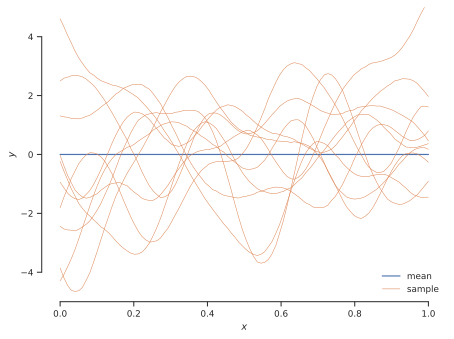

In [916]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

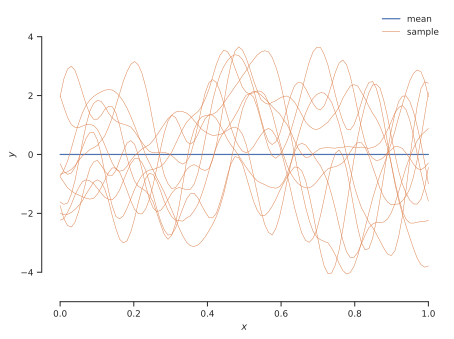

In [917]:
# Your code here
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 3.0
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

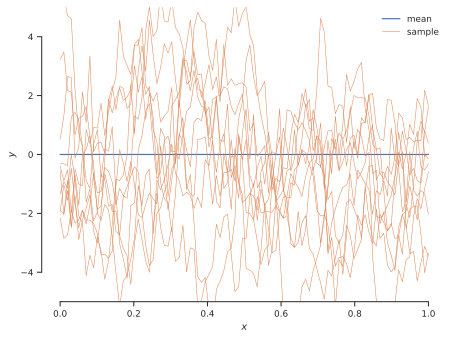

In [918]:
# Your code here
from gpytorch.kernels import MaternKernel

# Define the covariance function
k = ScaleKernel(MaternKernel(nu=0.5))
k.outputscale = 5.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

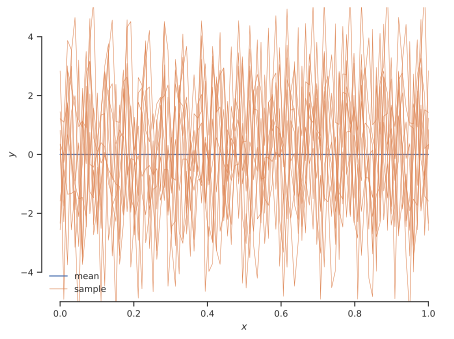

In [919]:
# Your code here
from gpytorch.kernels import PeriodicKernel

# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.outputscale = 5.0
k.base_kernel.period_length = 0.1
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

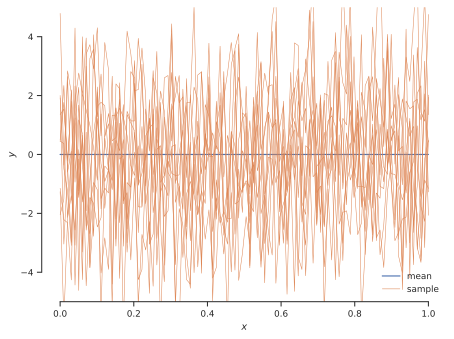

In [920]:
# Your code here
# Define the covariance function
k = ScaleKernel(PeriodicKernel())
k.outputscale = 5.0
k.base_kernel.period_length = 0.1
k.base_kernel.lengthscale = 0.01

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

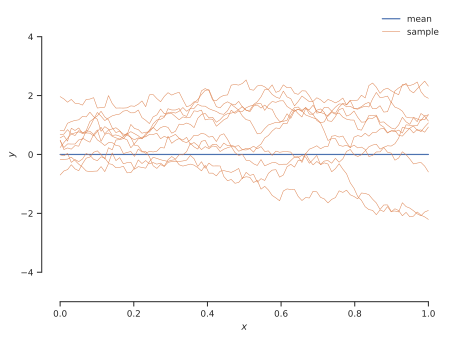

In [921]:
# Your code here
# Define kernel for f1(x): smooth function
k1 = ScaleKernel(RBFKernel())
k1.outputscale = 2.0
k1.base_kernel.lengthscale = 0.5

# Define kernel for f2(x): rough, continuous but nowhere differentiable
k2 = ScaleKernel(MaternKernel(nu=0.5))
k2.outputscale = 0.1
k2.base_kernel.lengthscale = 0.1

# Combine the two kernels additively
k = k1 + k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

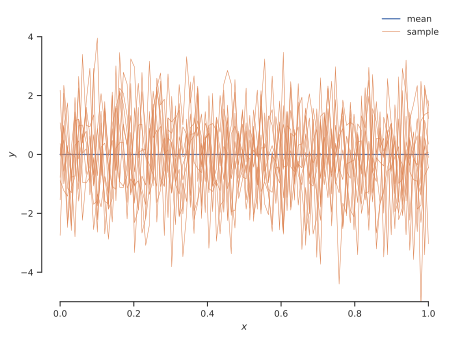

In [922]:
# Your code here
# Define kernel for f1(x): smooth, periodic with short scale
k1 = ScaleKernel(PeriodicKernel())
k1.outputscale = 2.0
k1.base_kernel.period_length = 0.1
k1.base_kernel.lengthscale = 0.01  # 0.1 * period = 0.01

# Define kernel for f2(x): smooth non-periodic
k2 = ScaleKernel(RBFKernel())
k2.outputscale = 1.0
k2.base_kernel.lengthscale = 0.5

# Combine the two kernels multiplicatively
k = k1 * k2

# Define the mean function (unknown trend)
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions (assuming sample_functions is defined elsewhere)
sample_functions(mean, k, nugget=1e-4)

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [923]:
url = "https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/lecturebook/data/mauna_loa_co2.txt"
!curl -O $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46015  100 46015    0     0   217k      0 --:--:-- --:--:-- --:--:--  218k


In [924]:
data = np.loadtxt('mauna_loa_co2.txt')

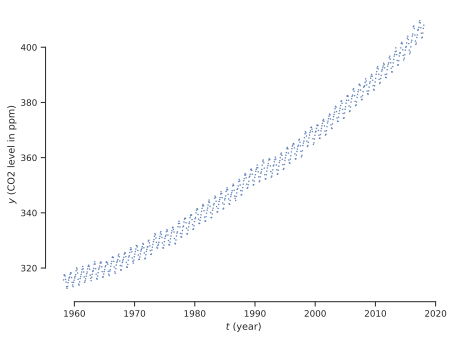

In [925]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

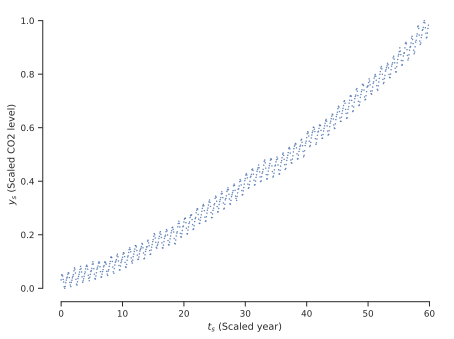

In [926]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [927]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7353, grad_fn=<NegBackward0>)
tensor(-2.1123, grad_fn=<NegBackward0>)
tensor(-2.2573, grad_fn=<NegBackward0>)
tensor(-2.0044, grad_fn=<NegBackward0>)
tensor(-2.2871, grad_fn=<NegBackward0>)
tensor(-2.3023, grad_fn=<NegBackward0>)
tensor(-2.3135, grad_fn=<NegBackward0>)
tensor(-2.3297, grad_fn=<NegBackward0>)
tensor(-2.3330, grad_fn=<NegBackward0>)
tensor(-2.2609, grad_fn=<NegBackward0>)
tensor(-2.3376, grad_fn=<NegBackward0>)
tensor(-2.3396, grad_fn=<NegBackward0>)
tensor(-2.3418, grad_fn=<NegBackward0>)
tensor(-2.3452, grad_fn=<NegBackward0>)
tensor(-2.3467, grad_fn=<NegBackward0>)
tensor(-2.3478, grad_fn=<NegBackward0>)
tensor(-2.3483, grad_fn=<NegBackward0>)
tensor(-2.3508, grad_fn=<NegBackward0>)
tensor(-2.3504, grad_fn=<NegBackward0>)
tensor(-2.3522, grad_fn=<NegBackward0>)
tensor(-2.3530, grad_fn=<NegBackward0>)
tensor(-2.3531, grad_fn=<NegBackward0>)
It

Predict everything:

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


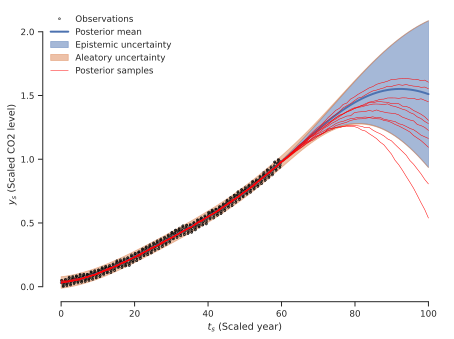

In [928]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**

In [929]:
periodic = PeriodicKernel()
periodic.initialize(period_length=1.0, lengthscale=0.2)

fluct = RBFKernel()
fluct.initialize(lengthscale=0.1)

#k1 = ScaleKernel(PeriodicKernel())
k1 = ScaleKernel(periodic * fluct)
k1.initialize(outputscale=0.1)
#k1.base_kernel.initialize(period_length=1.0, lengthscale=0.01)

k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 5.0
k2.outputscale = 1.0

cov_module = k1 + k2
mean_module = gpytorch.means.LinearMean(1)
model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model, train_x, train_y)

tensor(-0.0296, grad_fn=<NegBackward0>)
tensor(0.7342, grad_fn=<NegBackward0>)
tensor(-0.2846, grad_fn=<NegBackward0>)
tensor(-0.3122, grad_fn=<NegBackward0>)
tensor(-0.4411, grad_fn=<NegBackward0>)
tensor(-1.9154, grad_fn=<NegBackward0>)
tensor(-1.4228, grad_fn=<NegBackward0>)
tensor(-2.2260, grad_fn=<NegBackward0>)
tensor(-2.5341, grad_fn=<NegBackward0>)
tensor(-2.5467, grad_fn=<NegBackward0>)
tensor(-2.6616, grad_fn=<NegBackward0>)
tensor(-2.7666, grad_fn=<NegBackward0>)
tensor(-2.8400, grad_fn=<NegBackward0>)
tensor(-2.8764, grad_fn=<NegBackward0>)
tensor(-2.8979, grad_fn=<NegBackward0>)
tensor(-2.9246, grad_fn=<NegBackward0>)
tensor(-2.9336, grad_fn=<NegBackward0>)
tensor(-2.9440, grad_fn=<NegBackward0>)
tensor(-2.9512, grad_fn=<NegBackward0>)
tensor(-2.9597, grad_fn=<NegBackward0>)
tensor(-2.9576, grad_fn=<NegBackward0>)
tensor(-2.9710, grad_fn=<NegBackward0>)
tensor(-2.9762, grad_fn=<NegBackward0>)
tensor(-2.9685, grad_fn=<NegBackward0>)
tensor(-2.9774, grad_fn=<NegBackward0>)
I

Plot using the following block:

/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


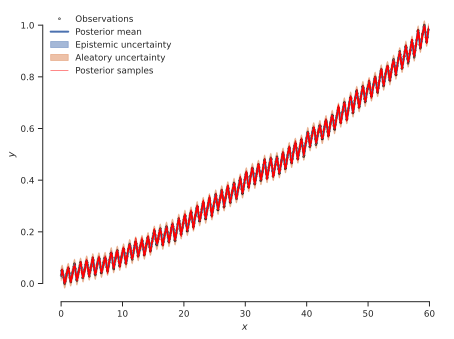

In [930]:
plot_1d_regression(model=model, x_star=train_x);

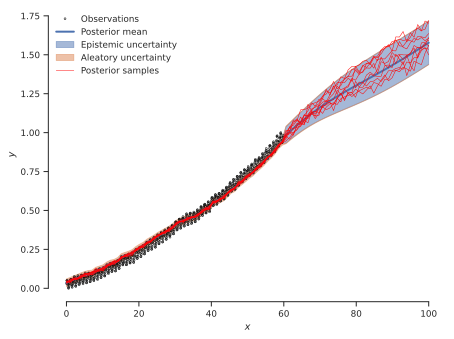

In [931]:
#future prediction
x_star2 = torch.linspace(0, 100, 100)
plot_1d_regression(model=model, x_star=x_star2);

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**<br>
A covariance function that combines both periodic and long-term trend components allows for more accurate future predictions by capturing recurring seasonal patterns along with the overall trajectory of the data. Unlike the naive model, which only models the general trend and treats seasonal variations as noise, my model can recognize and project repeating cycles into the future. This enables the Gaussian process to make structured, informed extrapolations rather than reverting to the mean, resulting in more realistic and accurate forecasts.

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**

In [932]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-30.4549], requires_grad=True),
 Parameter containing:
 tensor(0.5107, requires_grad=True),
 Parameter containing:
 tensor(-0.7554, requires_grad=True),
 Parameter containing:
 tensor([[34.6343]], requires_grad=True)]

In [933]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(m)

4


In [934]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(log_like)

tensor(1.2222, grad_fn=<DivBackward0>)


In [935]:
# Hint: The BIC is
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(bic)

tensor(23.8670, grad_fn=<AddBackward0>)


In [936]:
# Your code here
m2 = sum(p.numel() for p in model.hyperparameters())
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
log_like2 = mll2(model(train_x), train_y)
bic2 = -2 * log_like2 + m2 * np.log(train_x.shape[0])
print(bic2)

tensor(52.1530, grad_fn=<AddBackward0>)


## Problem 3 - Bayesian Global Optimization

As a toy example, we will apply Bayesian Optimization to some synthetic data. We will study the classic [Forrester function](https://www.sfu.ca/~ssurjano/forretal08.html)

$$
f(x) = (6x - 2)^2\sin(12x - 4)
$$

on the domain $[0,1]$. We will also $\textit{standardize}$ the output of the function, such that it has a mean of $0$ and a standard deviation of $1$. This is a good habit to get into when working with Gaussian processes. We will stick to a zero mean prior, so ensuring that the data has a mean of zero aligns with this.

The mean and standard deviation of this function on $[0,1]$ are known:
$$
\begin{aligned}
 \mu &= 0.45321 \\
 \mathrm{std} &= 4.4248
\end{aligned}
$$

The goal is to find the minimum of this objective function.

### Part A - Visualize the function and generate some data

Let's visualize the ground truth objective function and our synthetic data. First, code the **standardized** Forrester function in a way that allows for **minimization** using our Bayesian global **maximization** algorithms from the lecture book.

(Hint: to minimize a function, you can maximize the negative of that function)

In [937]:
# your code here
def Forrester(x):
    """ground truth function to optimize"""
    x = np.atleast_1d(x)
    raw = (6 * x - 2)**2 * np.sin(12 * x - 4)
    mu = 0.45321
    sigma = 4.4248
    return (raw - mu) / sigma

In [938]:
# making synthetic data from your function

np.random.seed(539)

sigma_noise = 0.025

# noisy version of the above function
F_noisy = lambda x: (
    Forrester(x)
    + sigma_noise * np.random.randn(x.shape[0])
)

# generate synthetic data
n_init = 5
X = np.random.rand(n_init)
Y = F_noisy(X)

train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

Plot it on $[0,1]$ and make sure to include the data points

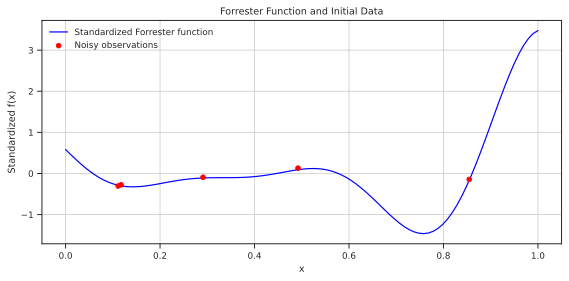

In [939]:
# your code here
xs = np.linspace(0, 1, 100)
ys = Forrester(xs)

plt.figure(figsize=(8, 4))
plt.plot(xs, ys, label='Standardized Forrester function', color='blue')
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Noisy observations', zorder=5)
plt.xlabel('x')
plt.ylabel('Standardized f(x)')
plt.title('Forrester Function and Initial Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part B - Set up the Gaussian process model

Set up the Gaussian process model.

Specifically, use this:

1. A Matern covariance kernel
2. Zero mean function
3. A Gaussian likelihood model
4. Set the likelihood noise to the ground truth noise (since we assume it is known)

In [940]:
# your code here
# Define the Exact GP Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)

        # Zero mean prior
        self.mean_module = gpytorch.means.ZeroMean()

        # Matern covariance kernel (ν = 2.5 is smooth, ν = 0.5 is rougher)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Use the known noise level
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = sigma_noise  # set to known noise std dev squared
likelihood.raw_noise.requires_grad = False  # lock it from being optimized

# Instantiate model
model = GPModel(train_x, train_y, likelihood)

### Now train the model on the data points to optimize the rest of the hyperparameters

Here is the training function you should be using:

In [941]:
def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()

In [942]:
# your code here
train(model, train_x, train_y, n_iter=10, lr=0.1)

Iter   1/10 - Loss: 0.124
Iter   2/10 - Loss: -0.305
Iter   3/10 - Loss: -0.305
Iter   4/10 - Loss: -0.305
Iter   5/10 - Loss: -0.305
Iter   6/10 - Loss: -0.305
Iter   7/10 - Loss: -0.305
Iter   8/10 - Loss: -0.305
Iter   9/10 - Loss: -0.305
Iter  10/10 - Loss: -0.305


### Plot the trained model along with some sample paths

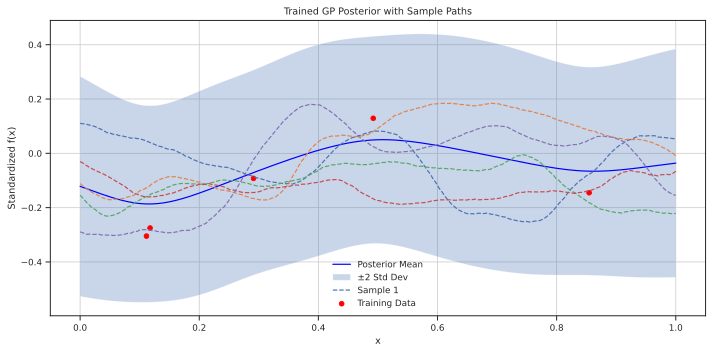

In [943]:
# your code here
# Evaluation grid
x_star = torch.linspace(0, 1, 200)
model.eval()
model.likelihood.eval()

# Predict posterior
with torch.no_grad():
    pred_dist = model.likelihood(model(x_star))
    mean = pred_dist.mean.numpy()
    lower, upper = pred_dist.confidence_region()
    lower = lower.numpy()
    upper = upper.numpy()

# Sample paths from posterior
with torch.no_grad():
    mvn = model(x_star)
    samples = mvn.rsample(torch.Size([5])).numpy()  # 5 samples

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_star.numpy(), mean, 'b', label='Posterior Mean')
plt.fill_between(x_star.numpy(), lower, upper, alpha=0.3, label='±2 Std Dev')
for i in range(5):
    plt.plot(x_star.numpy(), samples[i], '--', linewidth=1.2, label=f'Sample {i+1}' if i == 0 else None)
plt.scatter(train_x.numpy(), train_y.numpy(), color='red', label='Training Data')
plt.xlabel('x')
plt.ylabel('Standardized f(x)')
plt.title('Trained GP Posterior with Sample Paths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot the uncertainty about the optimization problem for the initial Gaussian process surrogate

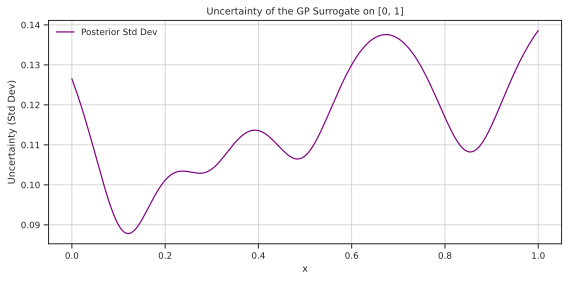

In [944]:
# your code here
model.eval()
model.likelihood.eval()

# Generate test points across the domain [0, 1]
x_star = torch.linspace(0, 1, 200)

# Predictive distribution
with torch.no_grad():
    posterior = model(x_star)
    std_dev = posterior.variance.sqrt().numpy()

# Plot the standard deviation
plt.figure(figsize=(8, 4))
plt.plot(x_star.numpy(), std_dev, color='purple', label='Posterior Std Dev')
plt.xlabel('x')
plt.ylabel('Uncertainty (Std Dev)')
plt.title('Uncertainty of the GP Surrogate on [0, 1]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Part C - Expected improvement with noise

Solve the optimization problem by applying the expected improvement with noise algorithm

In [945]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return m_star, v_star

def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None,
    iaf_label="Information Acquisition Function"
):
    """Plot the information acquisition function.

    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    alpha_params -- Extra parameters to the information
                    acquisition function.
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    iaf_label    -- The label for the information acquisition
                    function. Default is "Information Acquisition".

    The evaluation of the information acquisition function
    is as follows:

        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )

    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )

    sigma = torch.sqrt(v)
    af_values = alpha(m, sigma, gpr.train_targets.numpy().max(), **alpha_params)
    next_id = torch.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]

    ax2 = ax.twinx()
    ax2.plot(x_star, af_values.detach(), color=sns.color_palette()[1])
    ax2.set_ylabel(
        iaf_label,
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        torch.linspace(0, af_max.item(), 100),
        color=sns.color_palette()[1],
        linewidth=1
    )

def ei(m, sigma, ymax):
    """Return the expected improvement.

    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymin  -- The minimum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) +
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

def maximize(
    f,
    model,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.

    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowledge.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.

    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.

    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        f_design = model(X_design)
        m = f_design.mean
        sigma2 = f_design.variance
        sigma = torch.sqrt(sigma2)

        # Evaluate information acquisition function
        y_train = model.train_targets.numpy()
        af_values = alpha(
            m,
            sigma,
            y_train.max(),
            **alpha_params
        )

        # Find best point to include
        i = torch.argmax(af_values)
        af_all.append(af_values[i])

        new_x = X_design[i:(i+1)].float()
        new_y = f(new_x)
        train_x = torch.cat([model.train_inputs[0], new_x[:, None]])
        train_y = torch.cat([model.train_targets, new_y])
        model.set_train_data(train_x, train_y, strict=False)

        if optimize:
            train(model, train_x, train_y, n_iter=100, lr=0.1)
        else:
            model.train()
            model.eval()

        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                model,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax,
                **kwargs
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all

### run the algorithm

/tmp/ipython-input-945-1116358585.py:186: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  next_x * np.ones(100),


[tensor(0.0167, grad_fn=<SelectBackward0>),
 tensor(0.0103, grad_fn=<SelectBackward0>),
 tensor(0.0079, grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>),
 tensor(0., grad_fn=<SelectBackward0>)]

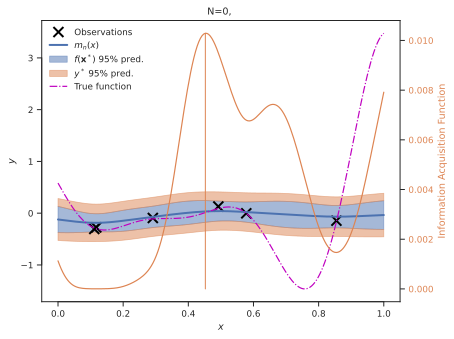

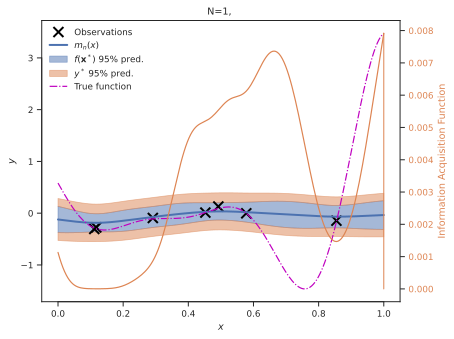

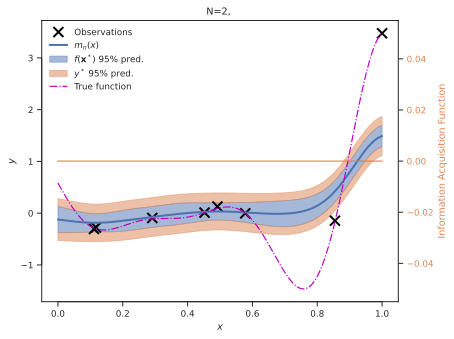

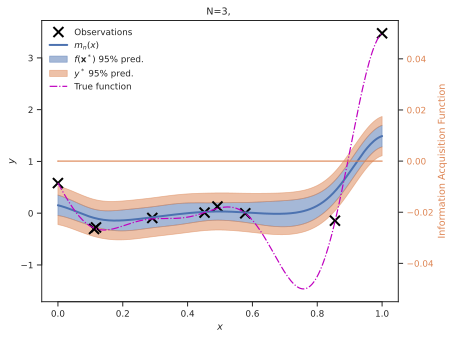

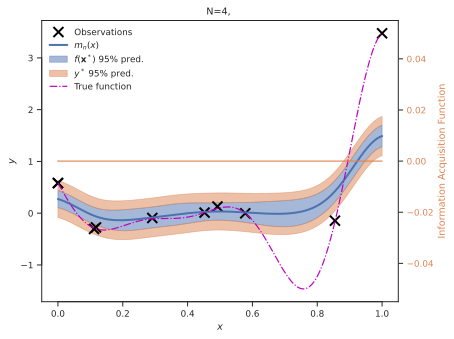

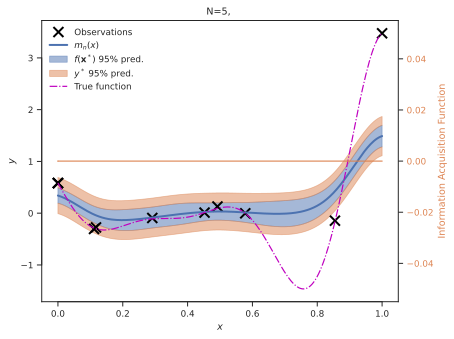

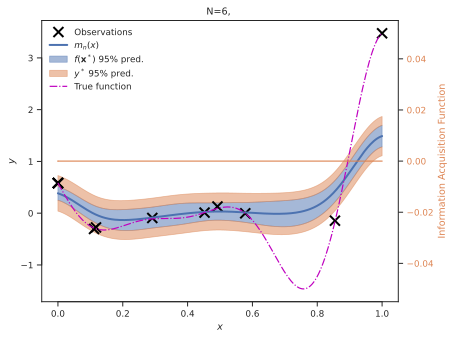

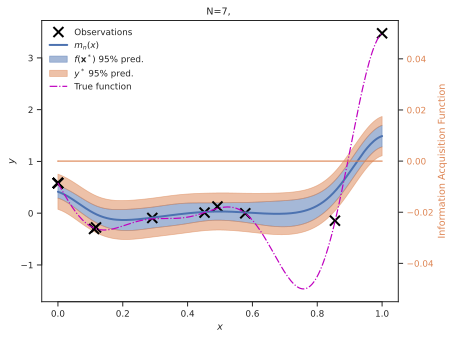

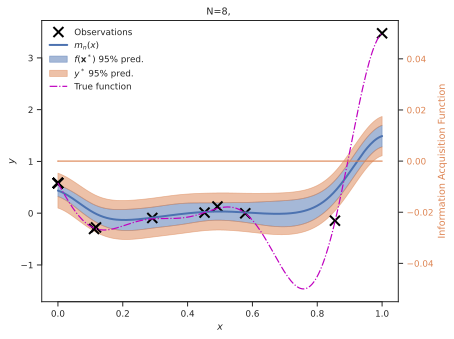

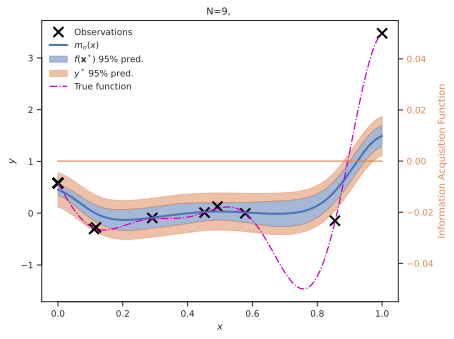

In [946]:
# your code here
# Wrap as torch function (for maximize loop)
f_true = lambda x: torch.from_numpy(Forrester(x.numpy())).float()

# 2. Create a dense design grid in [0,1]
X_design = torch.linspace(0, 1, 200)

# 3. Run Bayesian optimization loop using EI
maximize(
    f=f_true,
    model=model,
    X_design=X_design,
    alpha=ei,
    max_it=10,
    plot=1,  # Plot at every iteration
)

### How many iterations does the algorithm take to converge? That is, how quickly does it identify the critical point?

The algorithm converged by its fourth iteration. This is made clear by the expected improvement (EI) going from 0.0079 to 0 between the third and fourth iterations.

### Quantify the uncertainty about the solution to the optimization problem with the trained Gaussian process

Your answer here

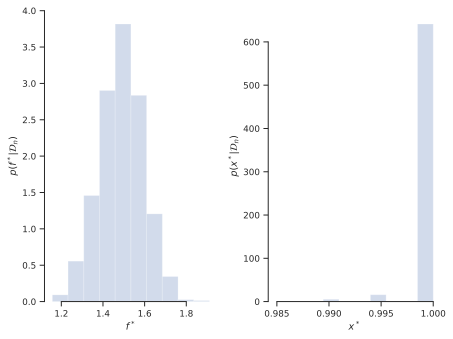

In [947]:
def plot_max_and_argmax(gpr, X_design, n_samples=1000):
    """Plot histograms of the max and argmax of the function represented by the model gpr.

    Arguments
    gpr      -- A trained Gaussian process object.
    X_design -- A set of points to evaluate the response on.

    Keyword Arguments
    n_samples -- The number of samples to take to make the histograms.
    """
    f_star = gpr(X_design)
    f_samples = f_star.sample(sample_shape=torch.Size([n_samples])).numpy()
    max_f_samples = np.max(f_samples, axis=1)
    x_star_samples = X_design.numpy()[np.argmax(f_samples, axis=1)]

    fig, ax = plt.subplots(1,2)
    ax[0].hist(max_f_samples, density=True, alpha=0.25)
    ax[0].set_xlabel('$f^*$')
    ax[0].set_ylabel(r'$p(f^*|\mathcal{D}_n)$')

    ax[1].hist(x_star_samples, density=True, alpha=0.25)
    ax[1].set_xlabel('$x^*$')
    ax[1].set_ylabel(r'$p(x^*|\mathcal{D}_n)$')

    plt.tight_layout()
    sns.despine(trim=True)

    return fig, ax

plot_max_and_argmax(model, x_star);

## Part D - Testing your intuition

In a real-world scenario, you may not be able to keep running experiments until the optimization problem has obviously converged due to time, budget considerations, etc. Imagine yourself in a situation where you are deciding whether or not to query the blackbox function an additional time.

Describe (in words) how you could make this decision using the principles you've learned in this course.

**Answer:**

To decide whether to query the blackbox function again, I would evaluate the acquisition function - such as Expected Improvement - which quantifies the expected reduction in loss from an additional query. If its maximum value is close to zero, it suggests that the model anticipates minimal gain in minimizing the loss and is confident in its current estimate of the optimum. I would also assess whether the surrogate model’s predictive uncertainty is low across the input space and whether recent iterations have failed to improve the minimum observed loss. If these conditions are met and querying is costly, I would stop. Otherwise, if there is still meaningful uncertainty in regions that could reduce loss, an additional query may be worthwhile.